In [1]:
"""
The exact formulation of the problem:
Given data going as far back as lookback timesteps (a timestep is 10 minutes)
and sampled every steps timesteps, can you predict the temperature in delay timesteps?
You’ll use the following parameter values:
- lookback = 720 — Observations will go back 5 days.
- steps = 6 — Observations will be sampled at one data point per hour.
- delay = 144 — Targets will be 24 hours in the future.
"""

'\nThe exact formulation of the problem:\nGiven data going as far back as lookback timesteps (a timestep is 10 minutes)\nand sampled every steps timesteps, can you predict the temperature in delay timesteps?\nYou’ll use the following parameter values:\n- lookback = 720 — Observations will go back 5 days.\n- steps = 6 — Observations will be sampled at one data point per hour.\n- delay = 144 — Targets will be 24 hours in the future.\n'

In [2]:
%reset
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


/Users/slechwar/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
DATA_DIR = '/Users/slechwar/dev/methods/sequences/forecasting'
TRAINING_SAMPLES = 200000

fname = os.path.join(DATA_DIR, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [4]:
%%time
def preprocessing(lines, training_samples):
    # Change all values to floats.
    # Remove 'Date Time' column from further processing.
    # Standardize the data.
    result = np.zeros((len(lines), len(header) - 1))
    for i, line in enumerate(lines):
        values = [float(x) for x in line.split(',')[1:]]
        result[i, :] = values

    mean = result[:training_samples].mean(axis=0)
    result -= mean
    std = result[:training_samples].std(axis=0)
    result /= std

    return result, mean, std

float_data, mean, std = preprocessing(lines, TRAINING_SAMPLES)

CPU times: user 2.54 s, sys: 104 ms, total: 2.65 s
Wall time: 2.81 s


In [5]:
'''
- data: The original array of floating-point data.
- lookback: How many timesteps back the input data should go.
- delay: How many timesteps in the future the target should be.
- min_index and max_index: Indices in the data array that delimit which timesteps
to draw from. This is useful for keeping a segment of the data for validation
and another for testing.
- shuffle: Whether to shuffle the samples or draw them in chronological order.
- batch_size: The number of samples per batch.
- step: The period, in timesteps, at which you sample data. You’ll set it to 6 in
order to draw one data point every hour.
'''
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        # Axis:
        # 0: Number of samples in the batch.
        # 1: Time axis (timestamp). Drawn data point (one hour interval).
        # 2: Features axis.
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
    
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

train_steps = (200000 - lookback)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [6]:
def plot_loss(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'bo', label='training loss')
    plt.plot(epochs, val_loss, 'b', label='validation loss')
    plt.legend()
    plt.show()

In [39]:
%%time
# Non-ML baseline to beat.
# Temperature in next 24h will be the same as temperature in current time.
# Lets calculate mean absolut error to check its performance.
# To speed things up, take onlt 1/100 of validation dataset.
def evaluate_naive_method(std):
    batch_maes = []
    for _ in range(val_steps // 100):
        samples, targets = next(val_gen)
        # Take all samples (axis 0),
        # from last period/timestamp (axis 1),
        # and feature "T (degC)" (axis 2)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    mean_batch_maes = np.mean(batch_maes)
    print('Mean MAE: {}'.format(mean_batch_maes))
    # Because the temperature data has been normalized to be
    # centered on 0 and have a standard deviation of 1, 
    # this number isn’t immediately interpretable.
    # Need to multiply with standard deviation to get interpretable value.
    print('Mean MAE (degrees Celsius): {}'.format(mean_batch_maes * std[1]))
    
evaluate_naive_method(std)

Mean MAE: 0.2848166608827257
Mean MAE (degrees Celsius): 2.521339229060914
CPU times: user 4.89 s, sys: 15.5 ms, total: 4.9 s
Wall time: 4.91 s


In [40]:
%%time
# Basic ML approach.
# Regression model.

def regression_model():
    model = tf.keras.models.Sequential()
    # Flatten expect shape without batches.
    # Note! It will remove notion of time.
    # Here we pass (number of timeseries samples, number of featuers).
    model.add(tf.keras.layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    # Last layer without activation (typical for regression problems).
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss='mae')
    model.summary()
    return model

model = regression_model()
# Bug probably...
# In order to run this, set:
# - steps_per_epoch=train_steps // batch_size,
# - validation_steps=val_steps // batch_size,
# - workers=1,
# - use_multiprocessing=False
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps // batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps // batch_size,
    workers=1,
    use_multiprocessing=False
)

plot_loss(history)
# Worse than baseline for validation sample...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1551/1551 [==============================] - 18s 12ms/step - loss: 0.5714 - val_loss: 0.3149
Epoch 2/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.2491 - val_loss: 0.3352
Epoch 3/20
1551/1551 [==============================] - 18s 11ms/step - loss: 0.2286 - val_loss: 0.3456
Epoch 4/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.2165 - v

In [ ]:
%%time
# Recurrent approach.
# Use Gated recurrent unit (GRU)
# Works using the same principle as LSTM
# but they’re somewhat streamlined and thus cheaper to run

def gru_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(32, input_shape=(None, float_data.shape[-1])))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    return model

model = gru_model()
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps // batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps // batch_size)

plot_loss(history)

Epoch 1/20
1551/1551 [==============================] - 282s 182ms/step - loss: 0.2862 - val_loss: 0.2659
Epoch 2/20
1551/1551 [==============================] - 282s 182ms/step - loss: 0.2692 - val_loss: 0.2605
Epoch 3/20
1551/1551 [==============================] - 281s 181ms/step - loss: 0.2568 - val_loss: 0.2667
Epoch 4/20
1551/1551 [==============================] - 283s 182ms/step - loss: 0.2444 - val_loss: 0.2807
Epoch 5/20
1551/1551 [==============================] - 286s 184ms/step - loss: 0.2306 - val_loss: 0.2873
Epoch 6/20
1551/1551 [==============================] - 287s 185ms/step - loss: 0.2199 - val_loss: 0.2982
Epoch 7/20
1551/1551 [==============================] - 303s 195ms/step - loss: 0.2107 - val_loss: 0.2968
Epoch 8/20
1551/1551 [==============================] - 303s 195ms/step - loss: 0.2030 - val_loss: 0.2959
Epoch 9/20
1551/1551 [==============================] - 306s 197ms/step - loss: 0.1966 - val_loss: 0.3014
Epoch 10/20
1551/1551 [=======================

Epoch 1/10
1551/1551 [==============================] - 365s 235ms/step - loss: 0.3209 - val_loss: 0.2703
Epoch 2/10
1551/1551 [==============================] - 359s 232ms/step - loss: 0.2998 - val_loss: 0.2668
Epoch 3/10
1551/1551 [==============================] - 370s 238ms/step - loss: 0.2931 - val_loss: 0.2684
Epoch 4/10
1551/1551 [==============================] - 366s 236ms/step - loss: 0.2894 - val_loss: 0.2629
Epoch 5/10
1551/1551 [==============================] - 379s 244ms/step - loss: 0.2852 - val_loss: 0.2635
Epoch 6/10
1551/1551 [==============================] - 384s 247ms/step - loss: 0.2820 - val_loss: 0.2650
Epoch 7/10
1551/1551 [==============================] - 364s 235ms/step - loss: 0.2800 - val_loss: 0.2668
Epoch 8/10
1551/1551 [==============================] - 371s 239ms/step - loss: 0.2778 - val_loss: 0.2671
Epoch 9/10
1551/1551 [==============================] - 374s 241ms/step - loss: 0.2762 - val_loss: 0.2648
Epoch 10/10
1551/1551 [=======================

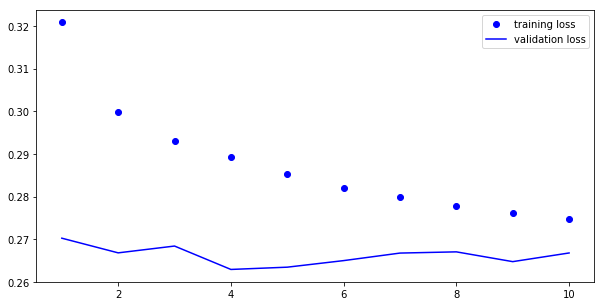

In [7]:
# Adding dropout...
def gru_model_with_dropout():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(
        32, 
        dropout=0.2,
        recurrent_dropout=0.2,
        input_shape=(None, float_data.shape[-1])))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    return model

model = gru_model_with_dropout()
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps // batch_size,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_steps // batch_size)

plot_loss(history)

Epoch 1/10
1551/1551 [==============================] - 827s 533ms/step - loss: 0.3227 - val_loss: 0.2697
Epoch 2/10
1551/1551 [==============================] - 813s 524ms/step - loss: 0.3022 - val_loss: 0.2631
Epoch 3/10
1551/1551 [==============================] - 807s 521ms/step - loss: 0.2930 - val_loss: 0.2702
Epoch 4/10
1551/1551 [==============================] - 811s 523ms/step - loss: 0.2872 - val_loss: 0.2664
Epoch 5/10
1551/1551 [==============================] - 807s 521ms/step - loss: 0.2818 - val_loss: 0.2634
Epoch 6/10
1551/1551 [==============================] - 810s 522ms/step - loss: 0.2752 - val_loss: 0.2685
Epoch 7/10
1551/1551 [==============================] - 740s 477ms/step - loss: 0.2715 - val_loss: 0.2669
Epoch 8/10
1551/1551 [==============================] - 670s 432ms/step - loss: 0.2686 - val_loss: 0.2692
Epoch 9/10
1551/1551 [==============================] - 680s 439ms/step - loss: 0.2649 - val_loss: 0.2733
Epoch 10/10
1551/1551 [=======================

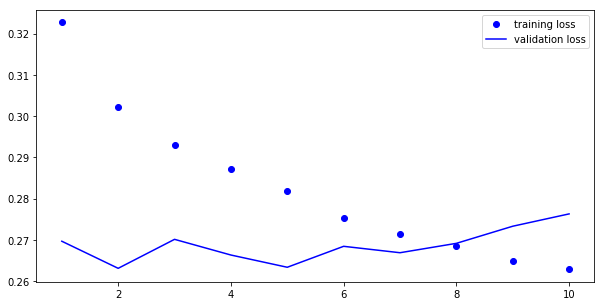

CPU times: user 6h 22min 9s, sys: 1h 36min 16s, total: 7h 58min 25s
Wall time: 2h 17min 16s


In [11]:
%%time
# Stackling recurrent layes.
# it’s generally a good idea to increase the
# capacity of your network until overfitting becomes the primary obstacle.
def gru_stacked_model_with_dropout():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(
        32,
        dropout=0.1,
        recurrent_dropout=0.5,
        return_sequences=True,
        input_shape=(None, float_data.shape[-1])))
    model.add(tf.keras.layers.GRU(
        64,
        dropout=0.1,
        recurrent_dropout=0.5))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    return model
    
model = gru_stacked_model_with_dropout()
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps // batch_size,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_steps // batch_size)

plot_loss(history)